# 锚框
> ⽬标检测算法通常会在输⼊图像中采样⼤量的区域，然后判断这些区域中是否包含我们感兴趣的⽬标，并调
整区域边界从⽽更准确地预测⽬标的真实边界框（ground-truth bounding box）。不同的模型使⽤的区域采样
⽅法可能不同。这⾥我们介绍其中的⼀种⽅法：以每个像素为中⼼，⽣成多个缩放⽐和宽⾼⽐（aspect ratio）
不同的边界框，这些边界框被称为锚框（anchor box）

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

## 1. 生成多个锚框

In [2]:
#@save
def multibox_prior(data, sizes, ratios):
    """⽣成以每个像素为中⼼具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # 为了将锚点移动到像素的中⼼，需要设置偏移量。
    # 因为⼀个像素的⾼为1且宽为1，我们选择偏移我们的中⼼0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # 在y轴上缩放步⻓
    steps_w = 1.0 / in_width # 在x轴上缩放步⻓
    # ⽣成锚框的所有中⼼点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # ⽣成“boxes_per_pixel”个⾼和宽，
    # 之后⽤于创建锚框的四⻆坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                    sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                    * in_height / in_width # 处理矩形输⼊
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                    sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半⾼和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2
    # 每个中⼼点都将有“boxes_per_pixel”个锚框，
    # 所以⽣成含所有锚框中⼼的⽹格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                            dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [3]:
img = d2l.plt.imread('./images/catdog.png')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

300 390


torch.Size([1, 585000, 4])

将锚框变量Y的形状更改为(图像⾼度,图像宽度,以同⼀像素为中⼼的锚框的数量,4)后，我们可以获得以指定
像素的位置为中⼼的所有锚框。

In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[200, 200, 0, :]

tensor([0.23, 0.29, 0.80, 1.04])

In [5]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                     va='center', ha='center', fontsize=9, color=text_color,
                     bbox=dict(facecolor=color, lw=0))

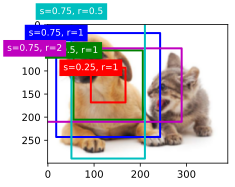

In [6]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[130, 130, :, :] * bbox_scale,
           ['s=0.75, r=1', 's=0.5, r=1','s=0.25, r=1','s=0.75, r=2','s=0.75, r=0.5'])

## 2. 交并比
> 可以衡量锚框和真实边界框之间的相似性。杰卡德系数（Jaccard）可以衡量两组之间的相似性。给定集合A和B，他们的杰卡德系数是他们交集的⼤⼩除以他们并集的⼤⼩.交并⽐的取值范围在0和1之间：0表⽰两个边界框⽆重合像素，1表⽰两个边界框完全重合。


In [7]:
#@save
def box_iou(boxes1, boxes2):
    # 计算两个锚框或者边界框列表成对的交并比
    # 匿名函数，计算面积
    box_area = lambda boxes : ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas - union_areas

## 3. 在训练数据中标注锚框
> 为了训练⽬标检测模型，我们需要每个锚框的类别（class）
和偏移量（offset）标签，其中前者是与锚框相关的对象的类别，后者是真实边界框相对于锚框的偏移量。在预测时，我们为每个图像⽣成多个锚框，预测所有锚框的类别和偏移量，根据预测的偏移量调整它们的位置以获得预测的边界框，最后只输出符合特定条件的预测边界框。


+ 将真实边界框分配给锚框
 给定图像，假设锚框是A1, A2, . . . , Ana，真实边界框是B1, B2, . . . , Bnb，其中na ≥ nb。让我们定义⼀个矩阵X ∈ Rna×nb，其中第i⾏、第j列的元素xij是锚框Ai和真实边界框Bj的IoU。该算法包含以下步骤。
+ 1. 在矩阵X中找到最⼤的元素，并将它的⾏索引和列索引分别表⽰为i1和j1。然后将真实边界框Bj1分配给锚框Ai1。这很直观，因为Ai1和Bj1是所有锚框和真实边界框配对中最相近的。在第⼀个分配完成后，丢弃矩阵中i1th⾏和j1th列中的所有元素。
+ 2. 在矩阵X中找到剩余元素中最⼤的元素，并将它的⾏索引和列索引分别表⽰为i2和j2。我们将真实边界框Bj2分配给锚框Ai2，并丢弃矩阵中i2th⾏和j2th列中的所有元素。
+ 3. 此时，矩阵X中两⾏和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵X中nb列中的所有元素。此时已经为这nb个锚框各⾃分配了⼀个真实边界框。
+ 4. 只遍历剩下的na − nb个锚框。例如，给定任何锚框Ai，在矩阵X的第ith⾏中找到与Ai的IoU最⼤的真实边界框Bj，只有当此IoU⼤于预定义的阈值时，才将Bj分配给Ai。

In [8]:
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    # 将最接近的真实边界框分配给锚框
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = box_iou(anchors, ground_truth)
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                 device=device)
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_anchors,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

+ 标记类别和偏移量
> 鉴于数据集内不同的框的位置和⼤⼩不同，我们可以对那些相对位置和⼤⼩应⽤
变换，使其获得分布更均匀且易于拟合的偏移量。

In [9]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset


In [10]:
#@save
def multibox_target(anchors, labels):
    """使⽤真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                    device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                    device=device)
        # 使⽤真实边界框来标记锚框的类别。
        # 如果⼀个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)


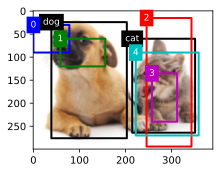

In [11]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                            [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                            [0.57, 0.3, 0.92, 0.9]])
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);
